# kNN and Naive Bayes

## 1. Load data from mongodb

In [470]:
# import mongo and pandas
from pymongo import MongoClient
import pandas as pd

In [471]:
def connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%d@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]

In [472]:
def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

In [473]:
raw_data = read_mongo('baochi', 'tuoitre')
raw_data.head(10)

,content,category
0,Võ sĩ MMA bị knock-out lạ kỳ vì... 'đụng đầu' ...,Thể thao
1,"Thi đấu từ máy bay ở độ cao 6.096m, ngôi sao 6...",Thể thao
2,Ấn Độ yêu cầu mạng xã hội gỡ cụm từ 'biến thể ...,Công nghệ
3,Tay đua 19 tuổi Jason Dupasquier qua đời sau t...,Thể thao
4,Cảnh sát Ấn Độ 'cảnh báo' Công ty Twitter TTO ...,Công nghệ
5,Sủng Cỏ thiên đường hoang sơ nơi cửa vịnh Đà N...,Du lịch
6,"Giận liên đoàn, CĐV Indonesia không vào sân cổ...",Thể thao
7,Google bỏ cookie theo dõi người dùng là để 'là...,Công nghệ
8,"Võ sĩ hạng nặng đánh nhau trên sàn đấu, khán g...",Thể thao
9,Bánh trứng thời nghèo khó Dan Bing bỗng len lỏ...,Du lịch


In [474]:
raw_data.groupby('category').size()

category
Công nghệ    474
Du lịch      455
Thể thao     445
dtype: int64

## 2. Split data into train - test sets

In [475]:
X = raw_data['content'].values
y = raw_data['category'].values

Since categories (label) are categorical variables, we need to convert categories into numbers.

In [476]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [477]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [478]:
X_train.shape

(1099,)

In [479]:
y_train.shape

(1099,)

In [480]:
X_test.shape

(275,)

In [481]:
y_test.shape

(275,)

## 3. Apply kNN

In [482]:
# import tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

In [483]:
# vectorize X train data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
vocab = vectorizer.get_feature_names()

In [484]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train_tfidf = onehot_encoder.fit_transform(y_train.reshape(len(y_train), 1))

In [485]:
y_train_tfidf

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [486]:
# import kNN
from sklearn.neighbors import KNeighborsClassifier

In [487]:
kNN = KNeighborsClassifier(n_neighbors=5)
# kNN.fit(X_train_tfidf, y_train_tfidf)
kNN.fit(X_train_tfidf, y_train)

KNeighborsClassifier()

In [488]:
# vectorize X test data
X_test_tfidf = vectorizer.transform(X_test).toarray()

In [489]:
# predict
y_pred = kNN.predict(X_test_tfidf)

In [490]:
# import accuracy and confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [491]:
# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

Accuracy of our model is equal 90.55 %.


In [492]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[86, 10,  2],
       [ 6, 79,  1],
       [ 2,  5, 84]])

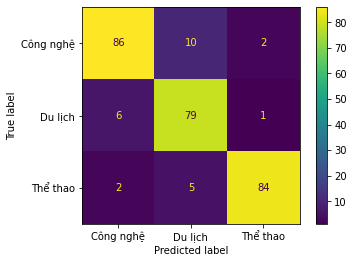

In [493]:
plot_confusion_matrix(kNN, X_test_knn, y_test, display_labels=le.classes_)  
plt.show()

In [494]:
# precision, recal and fbeta_score
precision_recall_fscore_support(le.inverse_transform(y_test), le.inverse_transform(y_pred), average=None, labels=le.classes_)

(array([0.91489362, 0.84042553, 0.96551724]),
 array([0.87755102, 0.91860465, 0.92307692]),
 array([0.89583333, 0.87777778, 0.94382022]),
 array([98, 86, 91]))

## 4. Apply Multinomial Naive Bayes without balancing data

In [495]:
# import packages
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [496]:
imbalanced_pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())
imbalanced_pipeline.fit(X_train, y_train)
y_imbalanced_pred = imbalanced_pipeline.predict(X_test)

In [497]:
# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

Accuracy of our model is equal 90.55 %.


In [498]:
# confusion matrix
cm = confusion_matrix(y_test, y_imbalanced_pred)
cm

array([[86, 10,  2],
       [ 6, 80,  0],
       [ 3,  2, 86]])

<ipython-input-499-fda9dfbfe44c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['']+labels)
<ipython-input-499-fda9dfbfe44c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['']+labels)


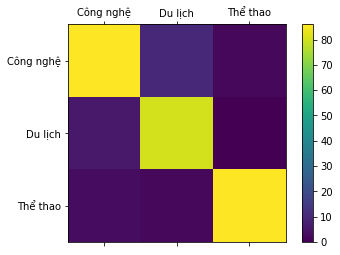

In [499]:
def plot_cm(cm, labels):
    figure = plt.figure()
    axes = figure.add_subplot(111)
    
    # using the matshow() function 
    caxes = axes.matshow(cm)
    figure.colorbar(caxes)
    
    axes.set_xticklabels(['']+labels)
    axes.set_yticklabels(['']+labels)
    
    plt.show()

plot_cm(cm, list(le.classes_))

In [500]:
# precision, recal and fbeta_score
precision_recall_fscore_support(le.inverse_transform(y_test), le.inverse_transform(y_imbalanced_pred), average=None, labels=le.classes_)

(array([0.90526316, 0.86956522, 0.97727273]),
 array([0.87755102, 0.93023256, 0.94505495]),
 array([0.89119171, 0.8988764 , 0.96089385]),
 array([98, 86, 91]))

## 5. Apply Multinomial Naive Bayes with balancing data

In [501]:
# import packages
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced

In [502]:
balanced_pipeline = make_pipeline_imb(TfidfVectorizer(), RandomUnderSampler(), MultinomialNB())
balanced_pipeline.fit(X_train, y_train)
y_balanced_pred = balanced_pipeline.predict(X_test)

In [503]:
# calculate accuracy score
accuracy = accuracy_score(y_test, y_balanced_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

Accuracy of our model is equal 92.36 %.


In [504]:
# confusion matrix
cm = confusion_matrix(y_test, y_balanced_pred)
cm

array([[86, 10,  2],
       [ 5, 81,  0],
       [ 2,  2, 87]])

<ipython-input-499-fda9dfbfe44c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['']+labels)
<ipython-input-499-fda9dfbfe44c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['']+labels)


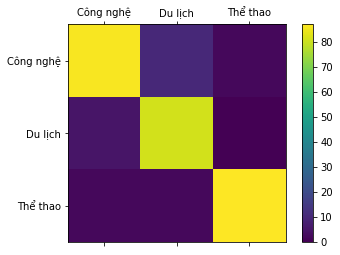

In [505]:
plot_cm(cm, list(le.classes_))

In [506]:
# precision, recal and fbeta_score
precision_recall_fscore_support(le.inverse_transform(y_test), le.inverse_transform(y_balanced_pred), average=None, labels=le.classes_)

(array([0.92473118, 0.87096774, 0.97752809]),
 array([0.87755102, 0.94186047, 0.95604396]),
 array([0.90052356, 0.90502793, 0.96666667]),
 array([98, 86, 91]))

## 6. Apply SVM

In [507]:
# import packages
from sklearn.svm import SVC 

### 6.1. Default kernel (rbf)

In [508]:
clf = SVC()
clf_rbf = clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

In [509]:
print('Accuraycy: ',clf_rbf.score(X_test_tfidf, y_test))

Accuraycy:  0.9236363636363636


In [510]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[89,  7,  2],
       [ 7, 79,  0],
       [ 2,  3, 86]])

<ipython-input-499-fda9dfbfe44c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['']+labels)
<ipython-input-499-fda9dfbfe44c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['']+labels)


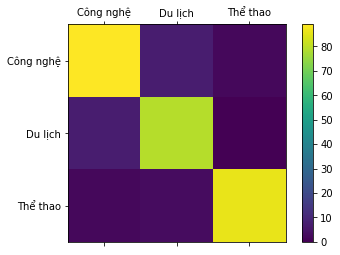

In [511]:
plot_cm(cm, list(le.classes_))

In [512]:
# precision, recal and fbeta_score
precision_recall_fscore_support(le.inverse_transform(y_test), le.inverse_transform(y_pred), average=None, labels=le.classes_)

(array([0.90816327, 0.88764045, 0.97727273]),
 array([0.90816327, 0.91860465, 0.94505495]),
 array([0.90816327, 0.90285714, 0.96089385]),
 array([98, 86, 91]))

### 6.2. Linear kernel

In [513]:
clf = SVC(kernel='linear')
clf_linear = clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

In [514]:
print('Accuraycy: ',clf_linear.score(X_test_tfidf, y_test))

Accuraycy:  0.9163636363636364


In [515]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[88,  8,  2],
       [ 8, 78,  0],
       [ 2,  3, 86]])

<ipython-input-499-fda9dfbfe44c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['']+labels)
<ipython-input-499-fda9dfbfe44c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['']+labels)


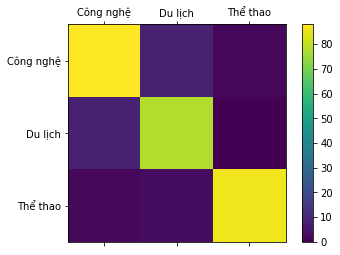

In [516]:
plot_cm(cm, list(le.classes_))

In [517]:
# precision, recal and fbeta_score
precision_recall_fscore_support(le.inverse_transform(y_test), le.inverse_transform(y_pred), average=None, labels=le.classes_)

(array([0.89795918, 0.87640449, 0.97727273]),
 array([0.89795918, 0.90697674, 0.94505495]),
 array([0.89795918, 0.89142857, 0.96089385]),
 array([98, 86, 91]))

### 6.3. Poly kernel

In [518]:
clf = SVC(kernel='poly')
clf_poly = clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

In [519]:
print('Accuraycy: ',clf_poly.score(X_test_tfidf, y_test))

Accuraycy:  0.8763636363636363


In [520]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[93,  3,  2],
       [15, 71,  0],
       [12,  2, 77]])

<ipython-input-499-fda9dfbfe44c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['']+labels)
<ipython-input-499-fda9dfbfe44c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['']+labels)


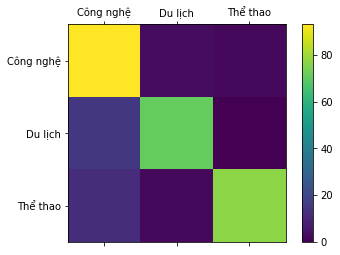

In [521]:
plot_cm(cm, list(le.classes_))

In [522]:
# precision, recal and fbeta_score
precision_recall_fscore_support(le.inverse_transform(y_test), le.inverse_transform(y_pred), average=None, labels=le.classes_)

(array([0.775     , 0.93421053, 0.97468354]),
 array([0.94897959, 0.8255814 , 0.84615385]),
 array([0.85321101, 0.87654321, 0.90588235]),
 array([98, 86, 91]))